In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Lasso
import statsmodels.api as sm
from sklearn import metrics
from sklearn import linear_model
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import IsolationForest
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from xgboost import XGBClassifier
import lightgbm as lgb

warnings.filterwarnings("ignore")
np.random.seed(1907)

df = pd.read_csv("Churn.csv")

print("The data size:", df.shape)

## Convert TotalCharges to numeric
df['TotalCharges']=pd.to_numeric(df['TotalCharges'],errors='coerce')

## Replace yes and No in the Churn column to 1 and 0. 1 for the event and 0 for the censured data.
df['Churn']=df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0 )
## Impute the null value with the median value
#df = df.rename(columns={'Churn': 'Class'})
#df.TotalCharges.fillna(value=df['TotalCharges'].mean(),inplace=True) #mean kullanınca başarı daha düşük
df.TotalCharges.fillna(value=df['TotalCharges'].median(),inplace=True)


labels = np.array(df['Churn'])
df= df.drop('Churn', axis = 1)
df= df.drop('customerID', axis = 1)# müşterinin id bilgisi bizim bilgi taşımadıgından silinmiştir. Silmeden önce feature importance değerlerine baktım 
#0 cıktı bu sebeple modeli eğitmeden bu nitegi sildim.
#df = pd.get_dummies(df) 



/Applications/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


The data size: (7043, 21)


In [3]:
unique, counts = np.unique(labels, return_counts=True)
dict(zip(unique, counts))

{0: 5174, 1: 1869}

In [4]:
#Data dengeli mi dağılıyor kontrolü
#df['Class'].value_counts()
unique, counts = np.unique(labels, return_counts=True)
dict(zip(unique, counts))
#0: 5174 1:1869  not balanced dataset exist.

unique, counts = np.unique(df['PaymentMethod'], return_counts=True)
dict(zip(unique, counts))
#gender:{'Female': 3488, 'Male': 3555}
#SeniorCitizen:{0: 5901, 1: 1142}
# Partner:{'No': 3641, 'Yes': 3402}
#Dependents{'No': 4933, 'Yes': 2110}
#PhoneService {'No': 682, 'Yes': 6361}
#MultipleLines {'No': 3390, 'No phone service': 682, 'Yes': 2971}
#InternetService {'DSL': 2421, 'Fiber optic': 3096, 'No': 1526}
#OnlineSecurity {'No': 3498, 'No internet service': 1526, 'Yes': 2019}
#OnlineBackup{'No': 3088, 'No internet service': 1526, 'Yes': 2429}
#DeviceProtection {'No': 3095, 'No internet service': 1526, 'Yes': 2422}
#TechSupport {'No': 3473, 'No internet service': 1526, 'Yes': 2044}
#StreamingTV {'No': 2810, 'No internet service': 1526, 'Yes': 2707}
#StreamingMovies {'No': 2785, 'No internet service': 1526, 'Yes': 2732}
#Contract {'Month-to-month': 3875, 'One year': 1473, 'Two year': 1695}
#PaperlessBilling {'No': 2872, 'Yes': 4171}
#PaymentMethod {'Bank transfer (automatic)': 1544,'Credit card (automatic)': 1522,'Electronic check': 2365,'Mailed check': 1612}



{'Bank transfer (automatic)': 1544,
 'Credit card (automatic)': 1522,
 'Electronic check': 2365,
 'Mailed check': 1612}

In [5]:
#preprocessing data encoding
df['gender']=df['gender'].map({'Female':0,'Male':1})
df['Partner']=df['Partner'].map({'No':0,'Yes':1})
df['PhoneService']=df['PhoneService'].map({'No':0,'Yes':1})
df['MultipleLines']=df['MultipleLines'].map({'No':0,'Yes':1,'No phone service':2})
df['Dependents']=df['Dependents'].map({'No':0,'Yes':1})
df['InternetService']=df['InternetService'].map({'DSL':0,'Fiber optic':1,'No':2})
df['OnlineSecurity']=df['OnlineSecurity'].map({'No':0,'Yes':1,'No internet service':2})
df['OnlineBackup']=df['OnlineBackup'].map({'No':0,'Yes':1,'No internet service':2})
df['DeviceProtection']=df['DeviceProtection'].map({'No':0,'Yes':1,'No internet service':2})
df['TechSupport']=df['TechSupport'].map({'No':0,'Yes':1,'No internet service':2})
df['StreamingTV']=df['StreamingTV'].map({'No':0,'Yes':1,'No internet service':2})
df['StreamingMovies']=df['StreamingMovies'].map({'No':0,'Yes':1,'No internet service':2})
df['Contract']=df['Contract'].map({'Month-to-month':0,'One year':1,'Two year':2})
df['PaperlessBilling']=df['PaperlessBilling'].map({'No':0,'Yes':1})
df['PaymentMethod']=df['PaymentMethod'].map({'Electronic check':0,'Mailed check':1,'Bank transfer (automatic)':2,'Credit card (automatic)':3})

In [7]:
#outlier detection 
def remove_outlier(data, col_name):
    OutlierList=[]
    q1 = data[col_name].quantile(0.25)
    q3 = data[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    lower  = q1-1.5*iqr
    higher = q3+1.5*iqr
    mean=data[col_name].mean()
    countOutlier=0
    for i in data[col_name].index:
        if((data[col_name][i]< lower )| (data[col_name][i]> higher)):
            countOutlier=countOutlier+1
            OutlierList.append(i)
            #data.loc[i,col_name]=mean
    print('Outlier sayisi',countOutlier) 
    return OutlierList

In [8]:
remove_outlier(df,'tenure')
remove_outlier(df,'MonthlyCharges')
remove_outlier(df,'TotalCharges')

Outlier sayisi 0
Outlier sayisi 0
Outlier sayisi 0


[]

In [17]:
def classificationAlgorithm(algorithm,train_x, test_x, train_y, test_y ):
    print('Algorithm:', type(algorithm).__name__)
    algorithm = algorithm.fit(train_x,train_y)
    y_pred = algorithm.predict(test_x)
    y_pred_prob = algorithm.predict_proba(test_x)[:,1]
    cf=confusion_matrix(test_y, y_pred)
    print('Confusion Matrix:')
    print(cf)
    print("Accuracy:",metrics.accuracy_score(test_y, y_pred))
    print ("AUC Score:", roc_auc_score(test_y, y_pred))
    print ("AUC Score prob:", roc_auc_score(test_y, y_pred_prob))
    print ("Precision:", precision_score(test_y, y_pred))
    print ("Recall:", recall_score(test_y, y_pred))
    print ("F1 Score:", f1_score(test_y, y_pred))

    feature_importances = pd.DataFrame(algorithm.feature_importances_,
                                  index = train_x.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

    print(feature_importances)
    print('Potential Churner Sayısı:',cf[0][1] +cf[1][1])
    

In [18]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(df, labels, test_size = 0.30, shuffle=False)


clf = DecisionTreeClassifier()
classificationAlgorithm(clf,train_x, test_x, train_y, test_y )

rfc = RandomForestClassifier(n_estimators=100, max_features=5)
classificationAlgorithm(rfc,train_x, test_x, train_y, test_y )

abc = AdaBoostClassifier(n_estimators=100, random_state=42)
classificationAlgorithm(abc,train_x, test_x, train_y, test_y )

sgb = GradientBoostingClassifier(n_estimators=100, random_state=42)
classificationAlgorithm(sgb,train_x, test_x, train_y, test_y )

etc = ExtraTreesClassifier(n_estimators=100, max_features=5)
classificationAlgorithm(etc,train_x, test_x, train_y, test_y )

##
#Accuracy: 0.7250354945575012
#AUC Score: 0.6502648626762939
#AUC Score prob: 0.6527425377330904
#Precision: 0.4991119005328597
#Recall: 0.4844827586206897



Algorithm: DecisionTreeClassifier
Confusion Matrix:
[[1270  263]
 [ 297  283]]
Accuracy: 0.7349739706578324
AUC Score: 0.6581859999550127
AUC Score prob: 0.6619699934768428
Precision: 0.5183150183150184
Recall: 0.4879310344827586
F1 Score: 0.5026642984014209
                  importance
TotalCharges        0.205218
MonthlyCharges      0.191935
Contract            0.169730
tenure              0.112464
OnlineSecurity      0.047507
PaymentMethod       0.039575
InternetService     0.029485
PaperlessBilling    0.027218
TechSupport         0.023009
Partner             0.021760
SeniorCitizen       0.019115
gender              0.018991
MultipleLines       0.018541
Dependents          0.018414
DeviceProtection    0.017311
OnlineBackup        0.014851
StreamingTV         0.012573
StreamingMovies     0.011845
PhoneService        0.000458
Potential Churner Sayısı: 546
Algorithm: RandomForestClassifier
Confusion Matrix:
[[1387  146]
 [ 297  283]]
Accuracy: 0.7903454803596782
AUC Score: 0.6963464696

In [10]:
df.isnull().sum()  

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

Optimal number of features : 19
Best features : ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges']


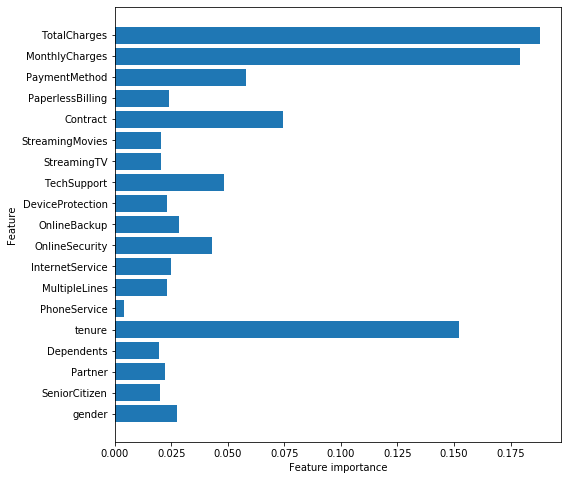

In [44]:
from sklearn.feature_selection import RFECV
cv_estimator = RandomForestClassifier(random_state =42)
cv_estimator.fit(train_x, train_y)
cv_selector = RFECV(cv_estimator,cv= 5, step=1,scoring='accuracy')
cv_selector = cv_selector.fit(train_x, train_y)
rfecv_mask = cv_selector.get_support() 
rfecv_features = [] 
for bool, feature in zip(rfecv_mask, train_x.columns):
    if bool:
        rfecv_features.append(feature)
    
print('Optimal number of features :', cv_selector.n_features_)
print('Best features :', rfecv_features)
n_features = train_x.shape[1]
plt.figure(figsize=(8,8))
plt.barh(range(n_features), cv_estimator.feature_importances_, align='center') 
plt.yticks(np.arange(n_features), train_x.columns.values) 
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

In [45]:
#en düşük feature importance'a sahip PhoneService cıkarıp tekrardan sınıflandırmanın başarısını ölçtüm.
data=df[['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
         'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 
         'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges']]
   
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(df, labels, test_size = 0.30, shuffle=False)

rfc = RandomForestClassifier(n_estimators=100, max_features=5)
classificationAlgorithm(rfc,train_x, test_x, train_y, test_y )

abc = AdaBoostClassifier(n_estimators=100, random_state=42)
classificationAlgorithm(abc,train_x, test_x, train_y, test_y )

sgb = GradientBoostingClassifier(n_estimators=100, random_state=42)
classificationAlgorithm(sgb,train_x, test_x, train_y, test_y )
   

Algorithm: RandomForestClassifier
Confusion Matrix:
[[1392  141]
 [ 298  282]]
Accuracy: 0.792238523426408
AUC Score: 0.6971151899588366
AUC Score prob: 0.8212609937692602
Precision: 0.6666666666666666
Recall: 0.4862068965517241
F1 Score: 0.5623130608175474
                  importance
TotalCharges        0.189907
MonthlyCharges      0.181102
tenure              0.145680
Contract            0.084263
PaymentMethod       0.058792
OnlineSecurity      0.051898
TechSupport         0.044577
gender              0.027456
OnlineBackup        0.025852
PaperlessBilling    0.024411
MultipleLines       0.023682
Partner             0.022065
DeviceProtection    0.021637
InternetService     0.021513
SeniorCitizen       0.019524
StreamingMovies     0.018783
Dependents          0.018457
StreamingTV         0.016312
PhoneService        0.004091
Potential Churner Sayısı: 423
Algorithm: AdaBoostClassifier
Confusion Matrix:
[[1387  146]
 [ 280  300]]
Accuracy: 0.7983909133932797
AUC Score: 0.711001642036124

In [180]:
#veriyi balance hale getirince recall score artmıstır.
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


random_seed = 63445
x_train, x_test, y_train, y_test = train_test_split(df, labels, test_size = 0.30, shuffle=False)


kf = StratifiedKFold(n_splits=5, random_state=random_seed)
cross_val_f1_score_lst = []
cross_val_accuracy_lst = []
cross_val_recall_lst = []
cross_val_precision_lst = []
total=0
totalChurner=0

for train_index_ls, validation_index_ls in kf.split(x_train, y_train):
    # keeping validation set apart and oversampling in each iteration using smote 
    train, validation = x_train.iloc[train_index_ls], x_train.iloc[validation_index_ls]
    target_train, target_val = y_train[train_index_ls], y_train[validation_index_ls]
    sm = SMOTE(random_state=random_seed)
    X_train_res, y_train_res = sm.fit_sample(train, target_train)
    
    # training the model on oversampled 4 folds of training set
    rf = RandomForestClassifier(n_estimators=100,  max_features=5,random_state=random_seed)
    rf.fit(X_train_res, y_train_res)
    # testing on 1 fold of validation set
    cf=confusion_matrix(target_val, validation_preds)
    print(cf)
    print('Potential Churner Sayısı:',cf[0][1] +cf[1][1])
    total=total+cf[0][0] +cf[0][1] +cf[1][0] +cf[1][1]
    totalChurner=totalChurner+cf[0][1] +cf[1][1]

    validation_preds = rf.predict(validation)
    cross_val_recall_lst.append(recall_score(target_val, validation_preds))
    cross_val_accuracy_lst.append(accuracy_score(target_val, validation_preds))
    cross_val_precision_lst.append(precision_score(target_val, validation_preds))
    cross_val_f1_score_lst.append(f1_score(target_val, validation_preds))
print ('Cross validated accuracy: {}'.format(np.mean(cross_val_accuracy_lst)))
print ('Cross validated recall score: {}'.format(np.mean(cross_val_recall_lst)))
print ('Cross validated precision score: {}'.format(np.mean(cross_val_precision_lst)))
print ('Cross validated f1_score: {}'.format(np.mean(cross_val_f1_score_lst)))


[[518 211]
 [196  61]]
Potential Churner Sayısı: 272
[[523 205]
 [185  73]]
Potential Churner Sayısı: 278
[[549 179]
 [181  77]]
Potential Churner Sayısı: 256
[[533 195]
 [182  76]]
Potential Churner Sayısı: 271
[[518 210]
 [171  87]]
Potential Churner Sayısı: 297
Cross validated accuracy: 0.775050709939148
Cross validated recall score: 0.6028081923204537
Cross validated precision score: 0.5671900924955322
Cross validated f1_score: 0.5841244383598225
